In [1]:
import tensorflow as tf

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib import rnn
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# Training Parameters
learning_rate = 0.001
training_steps = 10000
batch_size = 128
display_step = 200

# Network Parameters
depth1 = 32
depth2 = 64
num_input = 7*depth2 # 
timesteps = 7 # feature shape 7*7
num_hidden = 128 # hidden layer num of features
num_classes = 10 # MNIST total classes (0-9 digits)
image_width = 28
image_height = 28

# tf Graph input
input_x = tf.placeholder("float", [None, image_width, image_height])
Y = tf.placeholder("float", [None, num_classes])

# Define weights
weights = {
    'forward': tf.Variable(tf.random_normal([num_hidden, num_classes])),
    'backward': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'forward': tf.Variable(tf.random_normal([num_classes])),
    'backward': tf.Variable(tf.random_normal([num_classes]))
}


def cnn_model_fn(input_data):
    """Model function for CNN."""
  # Input Layer
    input_layer = tf.reshape(input_data, [-1, 28, 28, 1])
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    return pool2


def forwardRNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)
    # Define a lstm cell with tensorflow
    
    lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get lstm cell output
    with tf.variable_scope('forwardRNN'):
        outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['forward']) + biases['forward']
def backwardRNN(x, weights, biases):
    x = tf.unstack(x, timesteps, 1)
    # Define a lstm cell with tensorflow
    x.reverse()
    lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get lstm cell output
    with tf.variable_scope('backwardRNN'):
        outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['backward']) + biases['backward']

output_feature = cnn_model_fn(input_x)
output_feature = tf.reshape(output_feature,[-1,timesteps,num_input])
logits = forwardRNN(output_feature, weights, biases) + backwardRNN(output_feature,weights,biases)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [4]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
results = []
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, image_width, image_height))
        # Run optimization op (backprop)
        _ ,acc = sess.run([train_op,accuracy], feed_dict={input_x: batch_x, Y: batch_y})
        results.append(acc)
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={input_x: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, timesteps, num_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", 
        sess.run(accuracy, feed_dict={input_x: test_data, Y: test_label}))

Step 1, Minibatch Loss= 2.9235, Training Accuracy= 0.109
Step 200, Minibatch Loss= 0.1108, Training Accuracy= 0.969
Step 400, Minibatch Loss= 0.0479, Training Accuracy= 0.984
Step 600, Minibatch Loss= 0.0056, Training Accuracy= 1.000
Step 800, Minibatch Loss= 0.0513, Training Accuracy= 0.984
Step 1000, Minibatch Loss= 0.0111, Training Accuracy= 1.000
Step 1200, Minibatch Loss= 0.0612, Training Accuracy= 0.992
Step 1400, Minibatch Loss= 0.0443, Training Accuracy= 0.984
Step 1600, Minibatch Loss= 0.0256, Training Accuracy= 0.992
Step 1800, Minibatch Loss= 0.0131, Training Accuracy= 1.000
Step 2000, Minibatch Loss= 0.0215, Training Accuracy= 0.984
Step 2200, Minibatch Loss= 0.0014, Training Accuracy= 1.000
Step 2400, Minibatch Loss= 0.0057, Training Accuracy= 1.000
Step 2600, Minibatch Loss= 0.0101, Training Accuracy= 1.000
Step 2800, Minibatch Loss= 0.0025, Training Accuracy= 1.000
Step 3000, Minibatch Loss= 0.0107, Training Accuracy= 0.992
Step 3200, Minibatch Loss= 0.0015, Training Acc

NameError: name 'X' is not defined

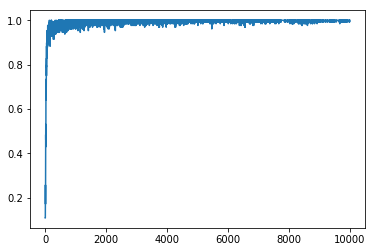

In [7]:
from matplotlib import pyplot as plt
plt.plot(range(training_steps),results)
plt.show()